In [ ]:
import zipfile

path_to_zip_file = '/content/datadenek2.zip'

directory_to_extract_to = '/content'

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [ ]:
from google.colab import files
import os

def zip_and_download(file_path):

    file_name = os.path.basename(file_path)

    zip_file_name = f"{file_name}.zip"
    os.system(f"zip -r {zip_file_name} {file_path}")

    files.download(zip_file_name)

file_path = "/content/datadenek2/beyin"
zip_and_download(file_path)


In [ ]:
import cv2
import os
import matplotlib.pyplot as plt

def crop_brain_contour(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    main_contour = sorted(contours, key=cv2.contourArea, reverse=True)[0]

    x, y, w, h = cv2.boundingRect(main_contour)

    cropped_image = image[y:y+h, x:x+w]

    return cropped_image

dataset_path = "/content/datadenek2/beyin/veri/no"

file_names = os.listdir(dataset_path)

for file_name in file_names:

    file_path = os.path.join(dataset_path, file_name)

    image = cv2.imread(file_path)

    cropped_image = crop_brain_contour(image)

    output_path = os.path.join("/content/datadenek2/beyin/veri/no1", "cropped_" + file_name)
    cv2.imwrite(output_path, cropped_image)

print("Tüm görüntüler başarıyla işlendi ve kaydedildi.")


Tüm görüntüler başarıyla işlendi ve kaydedildi.


Epoch 1/50
65/64 [==============================] - ETA: 0s - loss: 7.3612 - accuracy: 0.8487
Epoch 1: val_accuracy improved from -inf to 0.48753, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 28s 267ms/step - loss: 7.3612 - accuracy: 0.8487 - val_loss: 6.5796 - val_accuracy: 0.4875 - lr: 1.0000e-04
Epoch 2/50
65/64 [==============================] - ETA: 0s - loss: 5.2087 - accuracy: 0.8964
Epoch 2: val_accuracy did not improve from 0.48753
64/64 [==============================] - 13s 209ms/step - loss: 5.2087 - accuracy: 0.8964 - val_loss: 4.8946 - val_accuracy: 0.4875 - lr: 1.0000e-04
Epoch 3/50
65/64 [==============================] - ETA: 0s - loss: 3.6884 - accuracy: 0.9081
Epoch 3: val_accuracy did not improve from 0.48753
64/64 [==============================] - 12s 189ms/step - loss: 3.6884 - accuracy: 0.9081 - val_loss: 3.6306 - val_accuracy: 0.4875 - lr: 1.0000e-04
Epoch 4/50
65/64 [==============================] - ETA: 0s - loss: 2.6264 - accuracy: 0.9022
Epoch 4: val_accuracy did not improve from 0.48753
64/64 [==============================] - 14s 210ms/step - loss: 2.6264 - accuracy: 0.9022 - val_loss: 2.7328 - val_acc

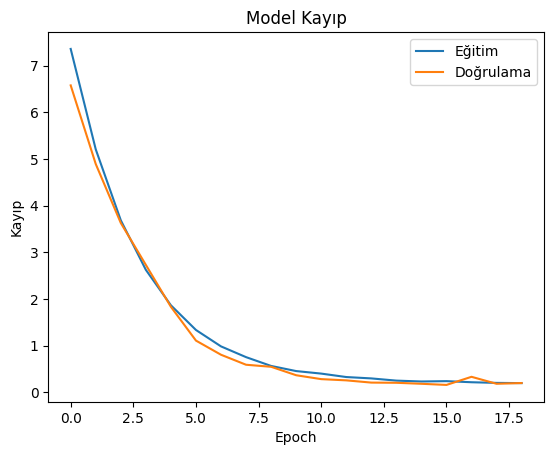

28/28 [==============================] - 4s 59ms/step
Kesinlik: 0.95
Hatırlama: 0.97
F1 Skoru: 0.96


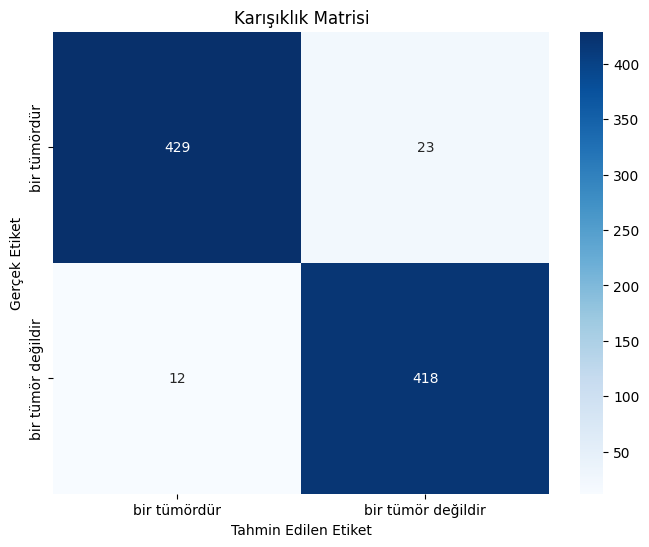

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns


train_yes_path = '/content/datadenek2/beyin/veri/yes1'
train_no_path = '/content/datadenek2/beyin/veri/no1'

data = []
labels = []

for r, d, f in os.walk(train_yes_path):
    for file in f:
        if file.endswith('.jpg'):
            img_path = os.path.join(r, file)
            img = Image.open(img_path)
            img = img.resize((128, 128))
            img = np.array(img)
            if img.shape == (128, 128, 3):
                data.append(img)
                labels.append(0)


for r, d, f in os.walk(train_no_path):
    for file in f:
        if file.endswith('.jpg'):
            img_path = os.path.join(r, file)
            img = Image.open(img_path)
            img = img.resize((128, 128))
            img = np.array(img)
            if img.shape == (128, 128, 3):
                data.append(img)
                labels.append(1)

if len(data) == 0 or len(labels) == 0:
    raise ValueError("Veriler veya etiketler boş. Lütfen veri yükleme sürecini kontrol edin.")

data = np.array(data)
labels = np.array(labels)

encoder = OneHotEncoder()
labels = encoder.fit_transform(labels.reshape(-1, 1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, shuffle=True, random_state=0)

x_train = x_train / 255.0
x_test = x_test / 255.0

train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
)

train_datagen.fit(x_train)

base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-20:]:
    layer.trainable = True

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=len(x_train) / 32,
    epochs=50,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint, lr_scheduler, early_stopping]
)

evaluation_results = model.evaluate(x_test, y_test)
accuracy = evaluation_results[1]
print("Test Setinde Model Doğruluğu: {:.2f}%".format(accuracy * 100))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Kayıp')
plt.ylabel('Kayıp')
plt.xlabel('Epoch')
plt.legend(['Eğitim', 'Doğrulama'], loc='upper right')
plt.show()

def names(number):
    if number == 0:
        return 'bir tümördür'
    else:
        return 'bir tümör değildir'

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

precision = precision_score(y_true_classes, y_pred_classes)
recall = recall_score(y_true_classes, y_pred_classes)
f1 = f1_score(y_true_classes, y_pred_classes)

print("Kesinlik: {:.2f}".format(precision))
print("Hatırlama: {:.2f}".format(recall))
print("F1 Skoru: {:.2f}".format(f1))

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['tümör bulunan', 'tümör bulunmayan'], yticklabels=['tümör bulunan', 'tümör bulunmayan'])
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.title('Karışıklık Matrisi')
plt.show()